In [1]:
import numpy as np
import torch

# initialize the RNG deterministically
np.random.seed(42)
torch.manual_seed(42)
torch.set_float32_matmul_precision('medium')

In [2]:
# parameters
dataset_name = ""
model_name = "resnet_edl_mse"
ood = ""

In [3]:
# Parameters
dataset_name = "MNIST"
ood = "5:6:7:8:9"


In [4]:
# initialize data attributes and loaders
from config import load_config

config = load_config(
    dataset_name = dataset_name,
    model_name = model_name,
    ood = ood,
)
config.load_data()
config.print_labels()
dm = config.datamodule

assert dm

  0%|                                                                                                                                                           | 0/60000 [00:00<?, ?it/s]

 11%|███████████████▉                                                                                                                             | 6804/60000 [00:00<00:00, 68031.63it/s]

 23%|███████████████████████████████▊                                                                                                            | 13608/60000 [00:00<00:00, 60695.89it/s]

 34%|███████████████████████████████████████████████▏                                                                                            | 20240/60000 [00:00<00:00, 63103.51it/s]

 45%|███████████████████████████████████████████████████████████████                                                                             | 27003/60000 [00:00<00:00, 64821.24it/s]

 56%|██████████████████████████████████████████████████████████████████████████████▏                                                             | 33519/60000 [00:00<00:00, 63428.20it/s]

 67%|█████████████████████████████████████████████████████████████████████████████████████████████▌                                              | 40075/60000 [00:00<00:00, 64127.25it/s]

 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████                               | 46717/60000 [00:00<00:00, 64856.94it/s]

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏               | 53217/60000 [00:00<00:00, 62904.89it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌| 59833/60000 [00:00<00:00, 63886.20it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 60000/60000 [00:00<00:00, 63654.38it/s]

  0%|                                                                                                                                                           | 0/10000 [00:00<?, ?it/s]

 68%|███████████████████████████████████████████████████████████████████████████████████████████████▏                                             | 6750/10000 [00:00<00:00, 67496.36it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:00<00:00, 66874.22it/s]

In [5]:
dm.setup("fit")
dm.setup("test")
dm.setup("predict")

In [6]:
# model ids
import pandas as pd
ood_str = ":".join(map(str, config.ood))
df = pd.read_csv("ids.csv").fillna("")
model_id = df[(df.dataset_name == dataset_name) & (df.model_name == model_name) & (df.ood == ood)].id.item()
print(ood_str, model_id)

5:6:7:8:9 7lnc1fg2


In [7]:
model = config.get_model()

In [8]:
from pathlib import Path
from lightning.pytorch.loggers.wandb import WandbLogger

artifact_dir = WandbLogger.download_artifact(artifact=f"yasith/robustml/model-{model_id}:best")
model = model.__class__.load_from_checkpoint(Path(artifact_dir) / "model.ckpt", config=config)
model = model.cuda()
model.eval();

wandb:   1 of 1 files downloaded.  


In [9]:
train_loader = dm.train_dataloader()
val_loader = dm.val_dataloader()
test_loader = dm.test_dataloader()
if ood_str:
    predict_loader = dm.predict_dataloader()

In [10]:
from tqdm import tqdm

trn_inp = []
trn_rcn = []
trn_emb = []
trn_lgt = []
trn_tgt = []

val_inp = []
val_rcn = []
val_emb = []
val_lgt = []
val_tgt = []

ind_inp = []
ind_rcn = []
ind_emb = []
ind_lgt = []
ind_tgt = []

if ood_str:
    ood_inp = []
    ood_rcn = []
    ood_emb = []
    ood_lgt = []
    ood_tgt = []

rnd_inp = []
rnd_rcn = []
rnd_emb = []
rnd_lgt = []

# train set (ind)
for batch_idx, batch in enumerate(tqdm(train_loader)):
    x, y, *_ = batch
    x = x.float().cuda()
    emb, lgt, rcn = model(x)
    trn_inp.extend(x.detach().cpu().numpy())
    trn_rcn.extend(rcn.detach().cpu().numpy())
    trn_emb.extend(emb.detach().cpu().numpy())
    trn_lgt.extend(lgt.detach().cpu().numpy())
    trn_tgt.extend(y.detach().cpu().numpy())
print("train - OK")

# val set (ind)
for batch_idx, batch in enumerate(tqdm(val_loader)):
    x, y, *_ = batch
    x = x.float().cuda()
    emb, lgt, rcn = model(x)
    val_inp.extend(x.detach().cpu().numpy())
    val_rcn.extend(rcn.detach().cpu().numpy())
    val_emb.extend(emb.detach().cpu().numpy())
    val_lgt.extend(lgt.detach().cpu().numpy())
    val_tgt.extend(y.detach().cpu().numpy())
print("val - OK")

# test set (ind)
for batch_idx, batch in enumerate(tqdm(test_loader)):
    x, y, *_ = batch
    x = x.float().cuda()
    emb, lgt, rcn = model(x)
    ind_inp.extend(x.detach().cpu().numpy())
    ind_rcn.extend(rcn.detach().cpu().numpy())
    ind_emb.extend(emb.detach().cpu().numpy())
    ind_lgt.extend(lgt.detach().cpu().numpy())
    ind_tgt.extend(y.detach().cpu().numpy())
print("test InD - OK")

# predict set (ood)
if ood_str:
    for batch_idx, batch in enumerate(tqdm(predict_loader)):
        x, y, *_ = batch
        x = x.float().cuda()
        emb, lgt, rcn = model(x)
        ood_inp.extend(x.detach().cpu().numpy())
        ood_rcn.extend(rcn.detach().cpu().numpy())
        ood_emb.extend(emb.detach().cpu().numpy())
        ood_lgt.extend(lgt.detach().cpu().numpy())
        ood_tgt.extend(y.detach().cpu().numpy())
    print("test OoD - OK")

# random set
rnd_set = torch.randn(100, config.batch_size, *config.input_shape)
for batch_idx, batch in enumerate(tqdm(rnd_set)):
    x = batch
    x = x.float().cuda()
    emb, lgt, rcn = model(x)
    rnd_inp.extend(x.detach().cpu().numpy())
    rnd_rcn.extend(rcn.detach().cpu().numpy())
    rnd_emb.extend(emb.detach().cpu().numpy())
    rnd_lgt.extend(lgt.detach().cpu().numpy())
print("test RnD - OK")

  0%|                                                                                                                                                             | 0/383 [00:00<?, ?it/s]

  0%|▍                                                                                                                                                    | 1/383 [00:00<03:28,  1.83it/s]

  5%|████████                                                                                                                                            | 21/383 [00:00<00:08, 42.70it/s]

 11%|███████████████▊                                                                                                                                    | 41/383 [00:00<00:04, 77.68it/s]

 16%|███████████████████████▍                                                                                                                           | 61/383 [00:00<00:03, 106.66it/s]

 21%|███████████████████████████████▍                                                                                                                   | 82/383 [00:00<00:02, 132.84it/s]

 27%|███████████████████████████████████████▎                                                                                                          | 103/383 [00:01<00:01, 153.12it/s]

 32%|██████████████████████████████████████████████▉                                                                                                   | 123/383 [00:01<00:01, 165.82it/s]

 37%|██████████████████████████████████████████████████████▌                                                                                           | 143/383 [00:01<00:01, 174.38it/s]

 43%|██████████████████████████████████████████████████████████████▏                                                                                   | 163/383 [00:01<00:01, 181.65it/s]

 48%|█████████████████████████████████████████████████████████████████████▊                                                                            | 183/383 [00:01<00:01, 186.41it/s]

 54%|██████████████████████████████████████████████████████████████████████████████▏                                                                   | 205/383 [00:01<00:00, 195.92it/s]

 59%|██████████████████████████████████████████████████████████████████████████████████████▌                                                           | 227/383 [00:01<00:00, 200.79it/s]

 65%|███████████████████████████████████████████████████████████████████████████████████████████████▎                                                  | 250/383 [00:01<00:00, 207.09it/s]

 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████▋                                          | 272/383 [00:01<00:00, 204.38it/s]

 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                  | 293/383 [00:01<00:00, 203.56it/s]

 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                          | 315/383 [00:02<00:00, 208.08it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                 | 338/383 [00:02<00:00, 213.49it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏        | 360/383 [00:02<00:00, 213.79it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 383/383 [00:02<00:00, 187.13it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 383/383 [00:02<00:00, 155.15it/s]

train - OK


  0%|                                                                                                                                                              | 0/96 [00:00<?, ?it/s]

  3%|████▋                                                                                                                                                 | 3/96 [00:00<00:03, 29.90it/s]

 27%|████████████████████████████████████████                                                                                                            | 26/96 [00:00<00:00, 147.41it/s]

 49%|████████████████████████████████████████████████████████████████████████▍                                                                           | 47/96 [00:00<00:00, 173.05it/s]

 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████▎                                            | 67/96 [00:00<00:00, 182.97it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏             | 87/96 [00:00<00:00, 187.69it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 96/96 [00:00<00:00, 151.50it/s]

val - OK


  0%|                                                                                                                                                              | 0/81 [00:00<?, ?it/s]

  1%|█▊                                                                                                                                                    | 1/81 [00:00<00:08,  9.56it/s]

 25%|████████████████████████████████████▌                                                                                                               | 20/81 [00:00<00:00, 110.83it/s]

 49%|█████████████████████████████████████████████████████████████████████████                                                                           | 40/81 [00:00<00:00, 147.91it/s]

 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                      | 60/81 [00:00<00:00, 165.24it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 81/81 [00:00<00:00, 152.58it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 81/81 [00:00<00:00, 135.34it/s]

test InD - OK


  0%|                                                                                                                                                             | 0/536 [00:00<?, ?it/s]

  0%|▎                                                                                                                                                    | 1/536 [00:00<00:57,  9.24it/s]

  4%|██████                                                                                                                                             | 22/536 [00:00<00:04, 121.37it/s]

  8%|████████████                                                                                                                                       | 44/536 [00:00<00:03, 162.38it/s]

 12%|██████████████████                                                                                                                                 | 66/536 [00:00<00:02, 183.71it/s]

 16%|███████████████████████▊                                                                                                                           | 87/536 [00:00<00:02, 191.85it/s]

 20%|█████████████████████████████▏                                                                                                                    | 107/536 [00:00<00:02, 192.99it/s]

 24%|██████████████████████████████████▊                                                                                                               | 128/536 [00:00<00:02, 197.12it/s]

 28%|████████████████████████████████████████▎                                                                                                         | 148/536 [00:00<00:01, 197.98it/s]

 31%|█████████████████████████████████████████████▊                                                                                                    | 168/536 [00:00<00:01, 197.69it/s]

 35%|███████████████████████████████████████████████████▏                                                                                              | 188/536 [00:01<00:01, 197.10it/s]

 39%|████████████████████████████████████████████████████████▋                                                                                         | 208/536 [00:01<00:01, 196.74it/s]

 43%|██████████████████████████████████████████████████████████████                                                                                    | 228/536 [00:01<00:01, 195.63it/s]

 46%|███████████████████████████████████████████████████████████████████▊                                                                              | 249/536 [00:01<00:01, 198.59it/s]

 50%|█████████████████████████████████████████████████████████████████████████▌                                                                        | 270/536 [00:01<00:01, 199.87it/s]

 54%|███████████████████████████████████████████████████████████████████████████████▎                                                                  | 291/536 [00:01<00:01, 201.13it/s]

 58%|████████████████████████████████████████████████████████████████████████████████████▉                                                             | 312/536 [00:01<00:01, 202.45it/s]

 62%|██████████████████████████████████████████████████████████████████████████████████████████▋                                                       | 333/536 [00:01<00:01, 202.90it/s]

 66%|████████████████████████████████████████████████████████████████████████████████████████████████▉                                                 | 356/536 [00:01<00:00, 210.33it/s]

 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉                                           | 378/536 [00:01<00:00, 210.12it/s]

 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                     | 400/536 [00:02<00:00, 205.25it/s]

 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                               | 421/536 [00:02<00:00, 204.79it/s]

 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                         | 442/536 [00:02<00:00, 200.61it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                    | 463/536 [00:02<00:00, 197.52it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌              | 483/536 [00:02<00:00, 195.20it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████         | 503/536 [00:02<00:00, 194.03it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍   | 523/536 [00:02<00:00, 195.11it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 536/536 [00:02<00:00, 187.96it/s]

test OoD - OK


  0%|                                                                                                                                                             | 0/100 [00:00<?, ?it/s]

 23%|█████████████████████████████████▊                                                                                                                 | 23/100 [00:00<00:00, 227.90it/s]

 48%|██████████████████████████████████████████████████████████████████████▌                                                                            | 48/100 [00:00<00:00, 236.96it/s]

 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                       | 73/100 [00:00<00:00, 239.38it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌    | 97/100 [00:00<00:00, 236.75it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 235.67it/s]

test RnD - OK


In [11]:
trn_inp = np.array(trn_inp)
trn_rcn = np.array(trn_rcn)
trn_emb = np.array(trn_emb).squeeze()
trn_lgt = np.array(trn_lgt).squeeze()
trn_tgt = np.array(trn_tgt)

val_inp = np.array(val_inp)
val_rcn = np.array(val_rcn)
val_emb = np.array(val_emb).squeeze()
val_lgt = np.array(val_lgt).squeeze()
val_tgt = np.array(val_tgt)

ind_inp = np.array(ind_inp)
ind_rcn = np.array(ind_rcn)
ind_emb = np.array(ind_emb).squeeze()
ind_lgt = np.array(ind_lgt).squeeze()
ind_tgt = np.array(ind_tgt)

if ood_str:
    ood_inp = np.array(ood_inp)
    ood_rcn = np.array(ood_rcn)
    ood_emb = np.array(ood_emb).squeeze()
    ood_lgt = np.array(ood_lgt).squeeze()
    ood_tgt = np.array(ood_tgt)

rnd_inp = np.array(rnd_inp)
rnd_rcn = np.array(rnd_rcn)
rnd_emb = np.array(rnd_emb).squeeze()
rnd_lgt = np.array(rnd_lgt).squeeze()

print(trn_inp.shape, trn_rcn.shape, trn_emb.shape, trn_lgt.shape, trn_tgt.shape)
print(val_inp.shape, val_rcn.shape, val_emb.shape, val_lgt.shape, val_tgt.shape)
print(ind_inp.shape, ind_rcn.shape, ind_emb.shape, ind_lgt.shape, ind_tgt.shape)
if ood_str:
    print(ood_inp.shape, ood_rcn.shape, ood_emb.shape, ood_lgt.shape, ood_tgt.shape)
print(rnd_inp.shape, rnd_rcn.shape, rnd_emb.shape, rnd_lgt.shape)

(24476, 1, 32, 32) (24476, 1, 32, 32) (24476, 256) (24476, 5) (24476,)
(6120, 1, 32, 32) (6120, 1, 32, 32) (6120, 256) (6120, 5) (6120,)
(5139, 1, 32, 32) (5139, 1, 32, 32) (5139, 256) (5139, 5) (5139,)
(34265, 1, 32, 32) (34265, 1, 32, 32) (34265, 256) (34265, 5) (34265,)
(6400, 1, 32, 32) (6400, 1, 32, 32) (6400, 256) (6400, 5)


In [12]:
from tsnecuda import TSNE

ind_ftr = ind_emb
if ood_str:
    ood_ftr = ood_emb
n = ind_ftr.shape[0]

if ood_str:
    all_ftr = np.concatenate([ind_ftr, ood_ftr], axis=0)
    all_lgt = np.concatenate([ind_lgt, ood_lgt], axis=0)
else:
    all_ftr = ind_ftr
    all_lgt = ind_lgt

tsne = TSNE(n_components=2, perplexity=1000, random_seed=42)
ftr2d = tsne.fit_transform(all_ftr)
ind_ftr2d = np.array(ftr2d[:n], order='C').astype(np.float32)
ood_ftr2d = np.array(ftr2d[n:], order='C').astype(np.float32)
print(ind_ftr2d.shape, ood_ftr2d.shape)

if all_lgt.shape[-1] > 2:
    tsne = TSNE(n_components=2, perplexity=1000, random_seed=42)
    lgt2d = tsne.fit_transform(all_lgt)
else:
    lgt2d = all_lgt
ind_lgt2d = np.array(lgt2d[:n], order='C').astype(np.float32)
ood_lgt2d = np.array(lgt2d[n:], order='C').astype(np.float32)
print(ind_lgt2d.shape, ood_lgt2d.shape)

(5139, 2) (34265, 2)


(5139, 2) (34265, 2)


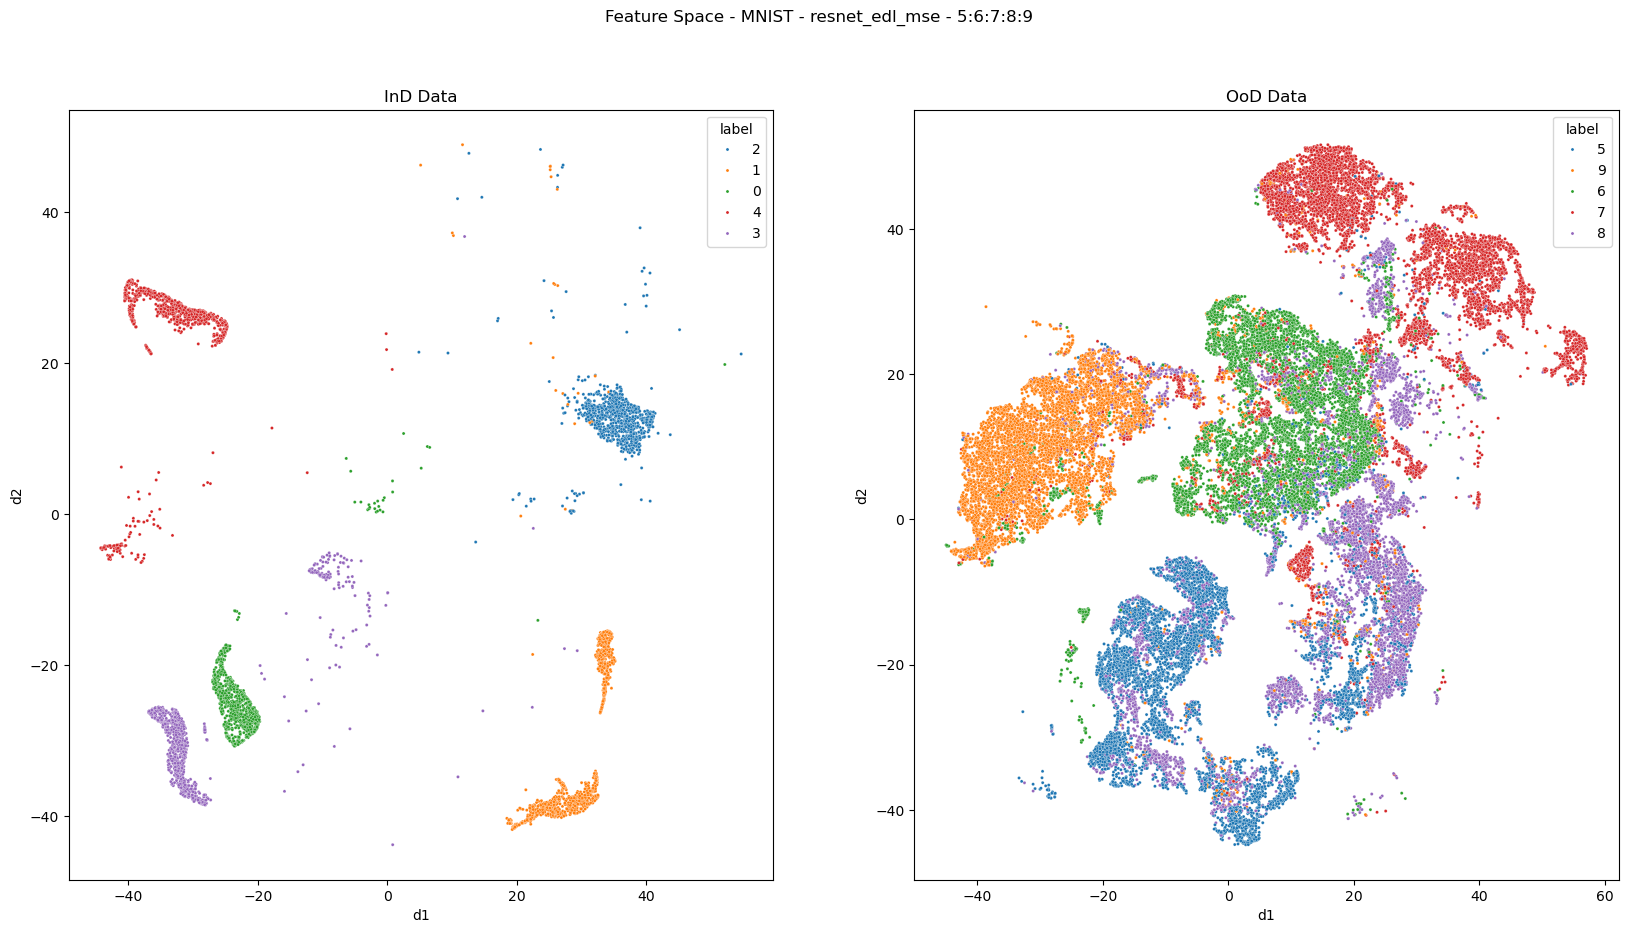

In [13]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

ind_labels = [config.labels[i] for i in ind_tgt]
if ood_str:
    ood_labels = [config.labels[i] for i in ood_tgt]

ftr_data = pd.DataFrame()
d1, d2 = ind_ftr2d.T
ftr_data = pd.concat([ftr_data, pd.DataFrame(dict(d1=d1, d2=d2, label=ind_labels, source="ind"))])

if ood_str:
    d1, d2 = ood_ftr2d.T
    ftr_data = pd.concat([ftr_data, pd.DataFrame(dict(d1=d1, d2=d2, label=ood_labels, source="ood"))])

fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(20, 10))
fig.suptitle(f"Feature Space - {dataset_name} - {model_name} - {ood_str}")
sns.scatterplot(data=ftr_data[(ftr_data['source'] == "ind")], x="d1", y="d2", hue="label", s=5, ax=ax1)
ax1.set_title("InD Data")
sns.scatterplot(data=ftr_data[(ftr_data['source'] == "ood")], x="d1", y="d2", hue="label", s=5, ax=ax2)
ax2.set_title("OoD Data")
plt.show()

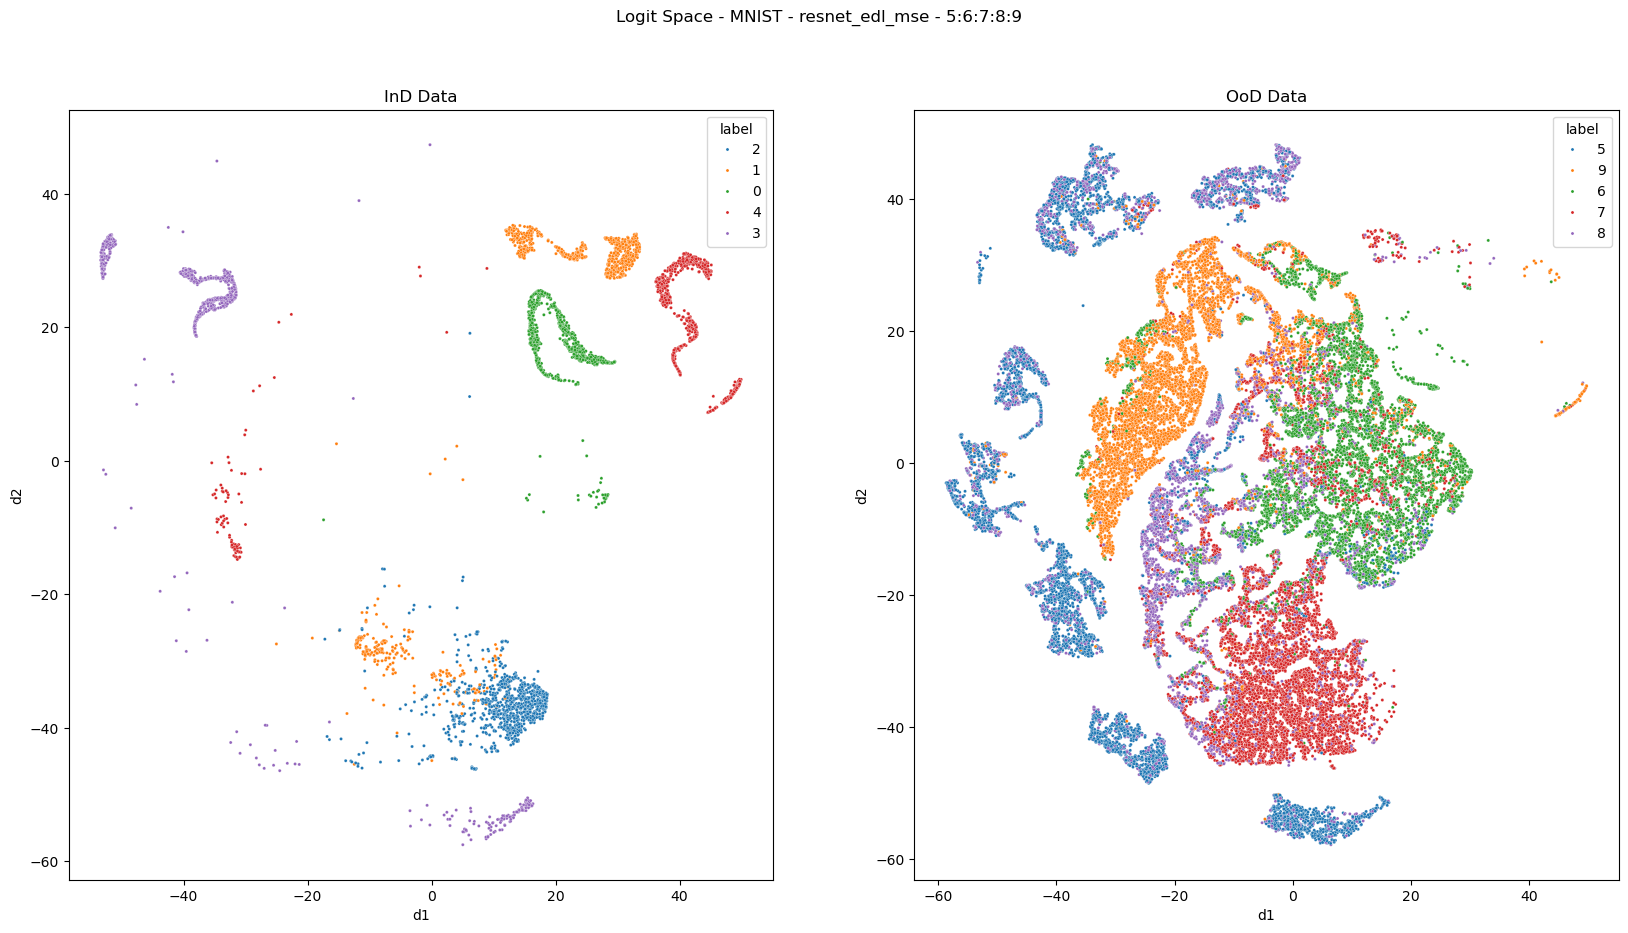

In [14]:
lgt_data = pd.DataFrame()
d1, d2 = ind_lgt2d.T
lgt_data = pd.concat([lgt_data, pd.DataFrame(dict(d1=d1, d2=d2, label=ind_labels, source="ind"))])

if ood_str:
    d1, d2 = ood_lgt2d.T
    lgt_data = pd.concat([lgt_data, pd.DataFrame(dict(d1=d1, d2=d2, label=ood_labels, source="ood"))])

fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(20, 10))
fig.suptitle(f"Logit Space - {dataset_name} - {model_name} - {ood_str}")
sns.scatterplot(data=lgt_data[(lgt_data['source'] == "ind")], x="d1", y="d2", hue="label", s=5, ax=ax1)
ax1.set_title("InD Data")
sns.scatterplot(data=lgt_data[(lgt_data['source'] == "ood")], x="d1", y="d2", hue="label", s=5, ax=ax2)
ax2.set_title("OoD Data")
plt.show()

  0%|                                                                                                                                                               | 0/4 [00:00<?, ?it/s]

 25%|█████████████████████████████████████▊                                                                                                                 | 1/4 [00:01<00:03,  1.11s/it]

 50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 2/4 [00:02<00:02,  1.24s/it]

 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                     | 3/4 [00:03<00:01,  1.24s/it]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:05<00:00,  1.31s/it]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:05<00:00,  1.27s/it]

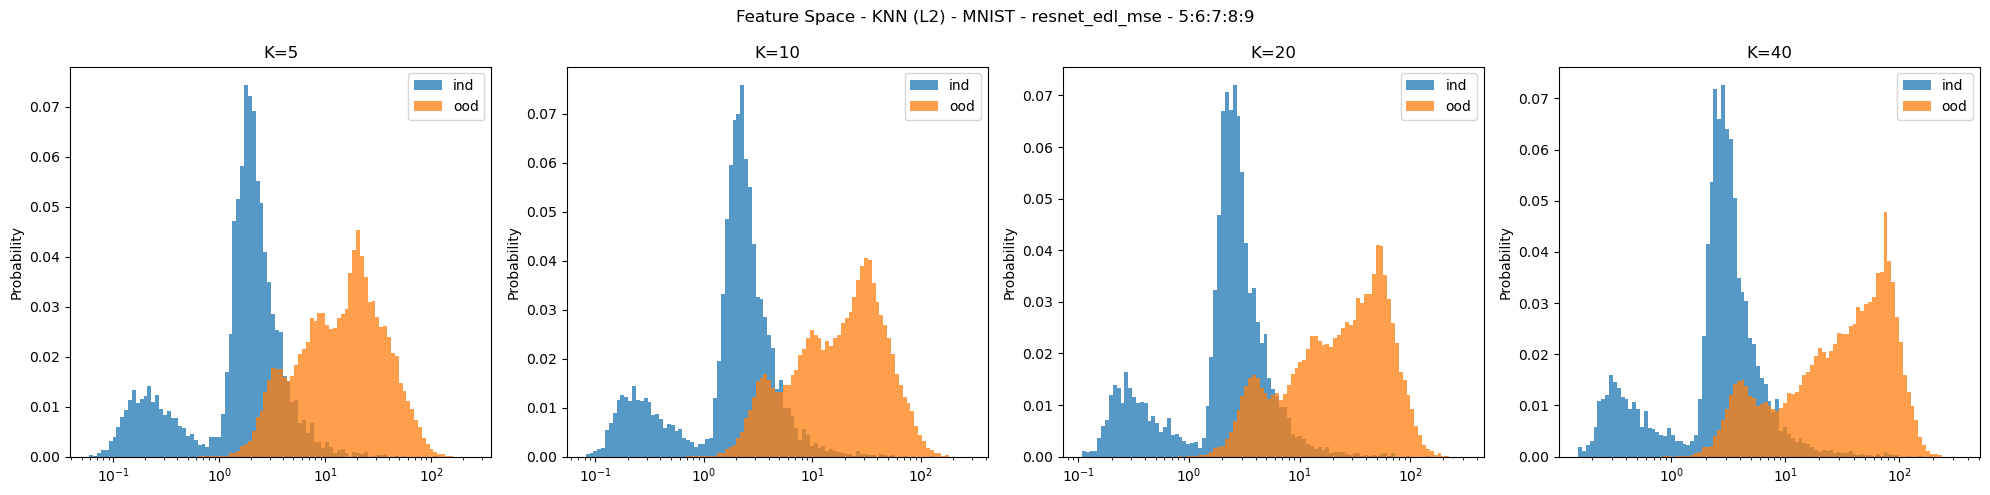

In [15]:
import faiss

index_ftr = faiss.IndexFlatL2(ind_ftr.shape[-1])
index_ftr.add(ind_ftr)

fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(20, 5))
fig.suptitle(f"Feature Space - KNN (L2) - {dataset_name} - {model_name} - {ood_str}")

for j, k in enumerate(tqdm([5, 10, 20, 40])):
    Di = index_ftr.search(ind_ftr, k+1)[0][:, -k:].mean(-1) # avoid closest neighbor (itself)
    D = [Di]
    if ood_str:
        Do = index_ftr.search(ood_ftr, k)[0].mean(-1)
        D.append(Do)
    D = np.concatenate(D, axis=0)
    bins = np.logspace(np.log10(D.min()), np.log10(D.max()), 100)
    ax = axs[j]
    sns.histplot(Di, fill=True, label='ind', stat='probability', ax=ax, bins=bins)
    if ood_str:
        sns.histplot(Do, fill=True, label='ood', stat='probability', ax=ax, bins=bins)
    ax.set_title(f"K={k}")
    ax.set_xscale('log')
    ax.legend()

plt.tight_layout()
plt.show()

  0%|                                                                                                                                                               | 0/4 [00:00<?, ?it/s]

 25%|█████████████████████████████████████▊                                                                                                                 | 1/4 [00:00<00:02,  1.05it/s]

 50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 2/4 [00:01<00:01,  1.02it/s]

 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                     | 3/4 [00:03<00:01,  1.17s/it]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:04<00:00,  1.21s/it]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:04<00:00,  1.15s/it]

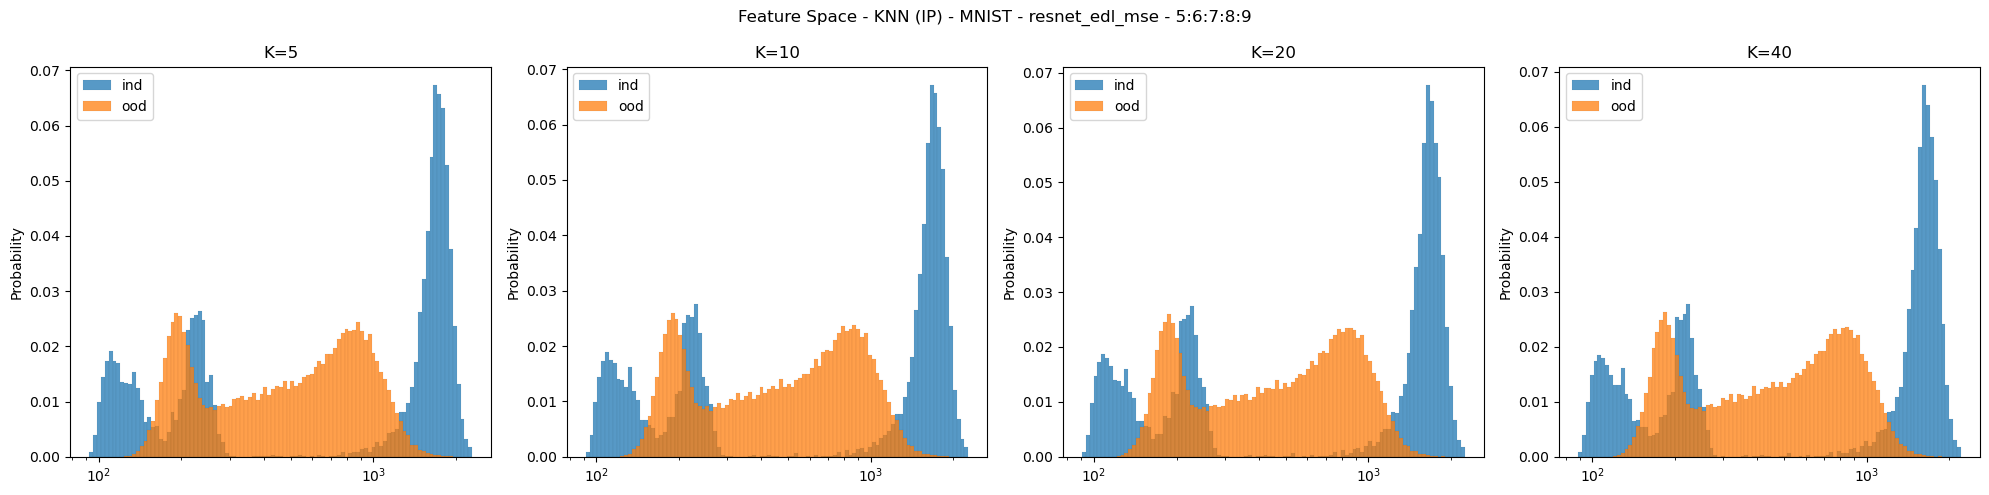

In [16]:
import faiss

index_ftr = faiss.IndexFlatIP(ind_ftr.shape[-1])
index_ftr.add(ind_ftr)

fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(20, 5))
fig.suptitle(f"Feature Space - KNN (IP) - {dataset_name} - {model_name} - {ood_str}")

for j, k in enumerate(tqdm([5, 10, 20, 40])):
    Di = index_ftr.search(ind_ftr, k+1)[0][:, -k:].mean(-1) # avoid closest neighbor (itself)
    D = [Di]
    if ood_str:
        Do = index_ftr.search(ood_ftr, k)[0].mean(-1)
        D.append(Do)
    D = np.concatenate(D, axis=0)
    bins = np.logspace(np.log10(D.min()), np.log10(D.max()), 100)
    ax = axs[j]
    sns.histplot(Di, fill=True, label='ind', stat='probability', ax=ax, bins=bins)
    if ood_str:
        sns.histplot(Do, fill=True, label='ood', stat='probability', ax=ax, bins=bins)
    ax.set_title(f"K={k}")
    ax.set_xscale('log')
    ax.legend()

plt.tight_layout()
plt.show()

  0%|                                                                                                                                                               | 0/4 [00:00<?, ?it/s]

 25%|█████████████████████████████████████▊                                                                                                                 | 1/4 [00:00<00:02,  1.06it/s]

 50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 2/4 [00:01<00:01,  1.04it/s]

 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                     | 3/4 [00:02<00:01,  1.02s/it]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:04<00:00,  1.12s/it]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:04<00:00,  1.07s/it]

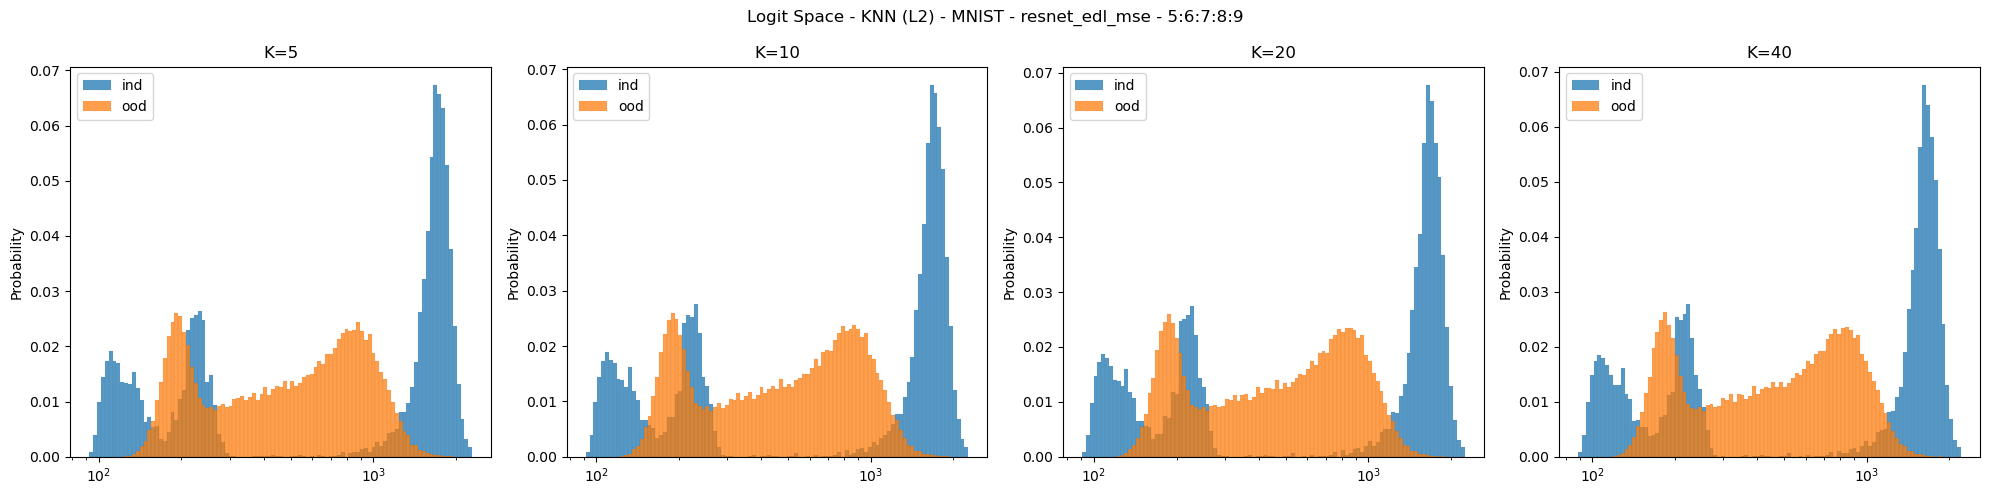

In [17]:
import faiss

index_lgt = faiss.IndexFlatL2(ind_lgt.shape[-1])
index_lgt.add(ind_lgt)

fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(20, 5))
fig.suptitle(f"Logit Space - KNN (L2) - {dataset_name} - {model_name} - {ood_str}")

for j, k in enumerate(tqdm([5, 10, 20, 40])):
    Di = index_ftr.search(ind_ftr, k+1)[0][:, -k:].mean(-1) # avoid closest neighbor (itself)
    D = [Di]
    if ood_str:
        Do = index_ftr.search(ood_ftr, k)[0].mean(-1)
        D.append(Do)
    D = np.concatenate(D, axis=0)
    bins = np.logspace(np.log10(D.min()), np.log10(D.max()), 100)
    ax = axs[j]
    sns.histplot(Di, fill=True, label='ind', stat='probability', ax=ax, bins=bins)
    if ood_str:
        sns.histplot(Do, fill=True, label='ood', stat='probability', ax=ax, bins=bins)
    ax.set_title(f"K={k}")
    ax.set_xscale('log')
    ax.legend()

plt.tight_layout()
plt.show()

  0%|                                                                                                                                                               | 0/4 [00:00<?, ?it/s]

 25%|█████████████████████████████████████▊                                                                                                                 | 1/4 [00:01<00:04,  1.36s/it]

 50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 2/4 [00:02<00:02,  1.17s/it]

 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                     | 3/4 [00:03<00:01,  1.13s/it]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:04<00:00,  1.18s/it]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:04<00:00,  1.18s/it]

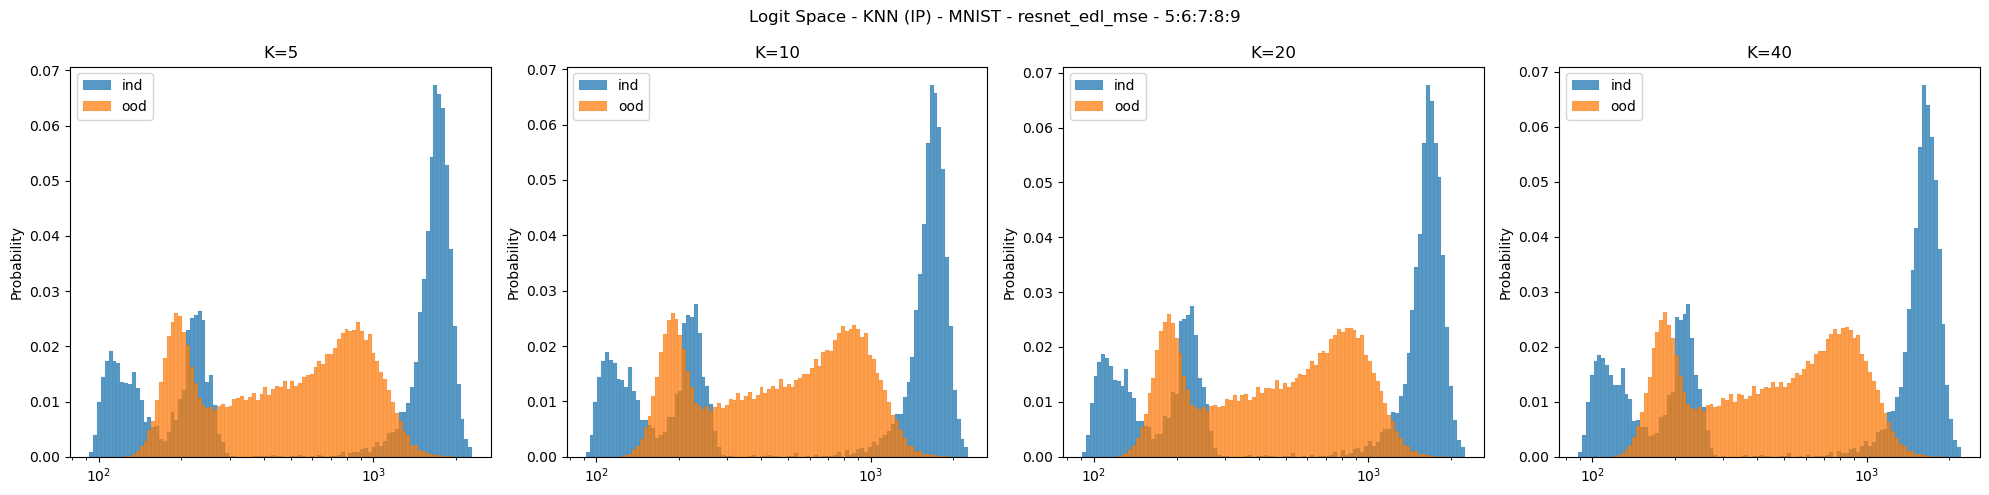

In [18]:
import faiss

index_lgt = faiss.IndexFlatIP(ind_lgt.shape[-1])
index_lgt.add(ind_lgt)

fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(20, 5))
fig.suptitle(f"Logit Space - KNN (IP) - {dataset_name} - {model_name} - {ood_str}")

for j, k in enumerate(tqdm([5, 10, 20, 40])):
    Di = index_ftr.search(ind_ftr, k+1)[0][:, -k:].mean(-1) # avoid closest neighbor (itself)
    D = [Di]
    if ood_str:
        Do = index_ftr.search(ood_ftr, k)[0].mean(-1)
        D.append(Do)
    D = np.concatenate(D, axis=0)
    bins = np.logspace(np.log10(D.min()), np.log10(D.max()), 100)
    ax = axs[j]
    sns.histplot(Di, fill=True, label='ind', stat='probability', ax=ax, bins=bins)
    if ood_str:
        sns.histplot(Do, fill=True, label='ood', stat='probability', ax=ax, bins=bins)
    ax.set_title(f"K={k}")
    ax.set_xscale('log')
    ax.legend()

plt.tight_layout()
plt.show()

/tmp/ipykernel_3689444/3659132256.py:1: RuntimeWarning: overflow encountered in exp
  ind_prob = np.exp(ind_lgt) / np.exp(ind_lgt).sum(-1, keepdims=True)
/tmp/ipykernel_3689444/3659132256.py:1: RuntimeWarning: invalid value encountered in divide
  ind_prob = np.exp(ind_lgt) / np.exp(ind_lgt).sum(-1, keepdims=True)


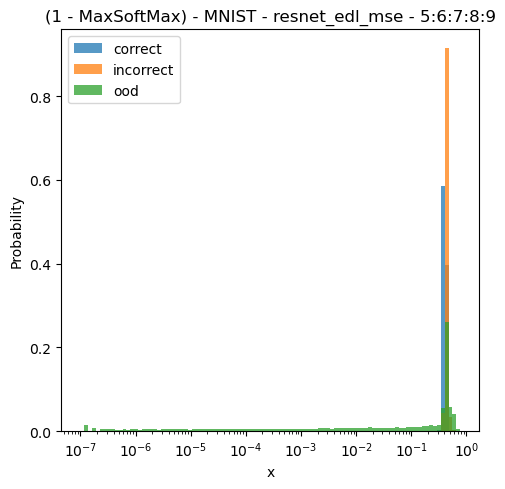

In [19]:
ind_prob = np.exp(ind_lgt) / np.exp(ind_lgt).sum(-1, keepdims=True)
ind_pred = ind_prob.argmax(-1)
ind_ucty = -ind_prob.max(-1) + 1.0

if ood_str:
    ood_prob = np.exp(ood_lgt) / np.exp(ood_lgt).sum(-1, keepdims=True)
    ood_pred = ood_prob.argmax(-1)
    ood_ucty = -ood_prob.max(-1) + 1.0

df_t = pd.DataFrame({"x": ind_ucty[ind_pred == ind_tgt]}).copy()
df_f = pd.DataFrame({"x": ind_ucty[ind_pred != ind_tgt]}).copy()
df = pd.concat([df_t, df_f], ignore_index=True)
if ood_str:
    df_o = pd.DataFrame({"x": ood_ucty}).copy()
    df = pd.concat([df, df_o], ignore_index=True)
df_bins = np.logspace(np.log10(df['x'].min() + 1e-7), np.log10(df['x'].max()), 100)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5, 5))
sns.histplot(df_t, x="x", label="correct", stat="probability", bins=df_bins, ax=ax)
sns.histplot(df_f, x="x", label="incorrect", stat="probability", bins=df_bins, ax=ax)
if ood_str:
    sns.histplot(df_o, x="x", label="ood", stat="probability", bins=df_bins, ax=ax)
ax.set_xscale("log")
plt.legend()
plt.title(f"(1 - MaxSoftMax) - {dataset_name} - {model_name} - {ood_str}")
plt.tight_layout()
plt.show()

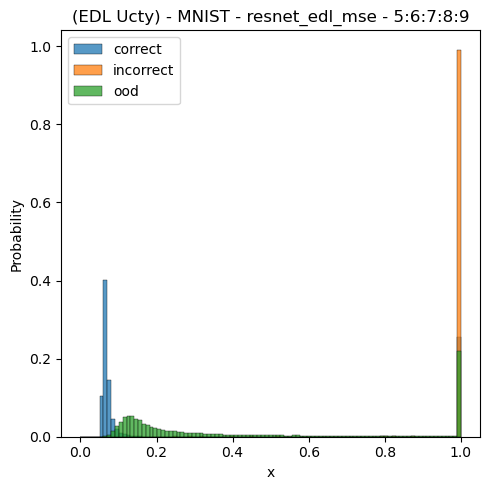

In [20]:
K = ind_lgt.shape[-1]
ind_belief = np.clip(ind_lgt, 0, None)
ind_pred = ind_lgt.argmax(-1)
ind_prob = ind_belief / (ind_belief.sum(-1, keepdims=True) + K)
ind_ucty = K / (ind_belief.sum(-1) + K)

if ood_str:
    ood_belief = np.clip(ood_lgt, 0, None)
    ood_pred = ood_lgt.argmax(-1)
    ood_prob = ood_belief / (ood_belief.sum(-1, keepdims=True) + K)
    ood_ucty = K / (ood_belief.sum(-1) + K)

df_t = pd.DataFrame({"x": ind_ucty[ind_pred == ind_tgt]}).copy()
df_f = pd.DataFrame({"x": ind_ucty[ind_pred != ind_tgt]}).copy()
df = pd.concat([df_t, df_f], ignore_index=True)
if ood_str:
    df_o = pd.DataFrame({"x": ood_ucty}).copy()
    df = pd.concat([df, df_o], ignore_index=True)
df_bins = np.linspace(0, 1, 100)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5, 5))
sns.histplot(df_t, x="x", label="correct", stat="probability", bins=df_bins, ax=ax)
sns.histplot(df_f, x="x", label="incorrect", stat="probability", bins=df_bins, ax=ax)
if ood_str:
    sns.histplot(df_o, x="x", label="ood", stat="probability", bins=df_bins, ax=ax)
plt.legend()
plt.title(f"(EDL Ucty) - {dataset_name} - {model_name} - {ood_str}")
plt.tight_layout()
plt.show()